# Ordinal Regression with GPflow

In [1]:
import GPflow
import tensorflow as tf
import matplotlib
import numpy as np
matplotlib.style.use('ggplot')
%matplotlib inline
plt = matplotlib.pyplot

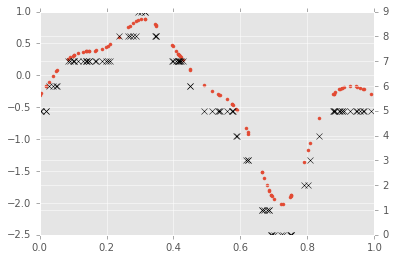

In [2]:
#make a one dimensional ordinal regression problem
np.random.seed(1)
X = np.random.rand(100,1)
K = np.exp(-0.5*np.square(X - X.T)/0.01) + np.eye(100)*1e-6
f = np.dot(np.linalg.cholesky(K), np.random.randn(100,1))

plt.plot(X, f, '.')
Y = np.round((f + f.min())*3)
Y = Y - Y.min()
Y = np.asarray(Y, np.int32)
plt.twinx()
plt.plot(X, Y, 'kx')

In [3]:
bin_edges = np.arange(np.unique(Y).size)
bin_edges = bin_edges - bin_edges.mean()
m = GPflow.svgp.SVGP(X, Y, 
                     kern=GPflow.kernels.Matern32(1) + GPflow.kernels.White(1, variance=0.01),
                     likelihood=GPflow.likelihoods.Ordinal(bin_edges),
                     Z=X[::5].copy(), whiten=True, q_diag=True)

In [4]:
m.kern.white.variance.fixed = True
m.Z.fixed = True
m.likelihood.num_gauss_hermite_points = 4
_ = m.optimize()


compiling tensorflow function...
done


InvalidArgumentError: Input matrix is not invertible.
	 [[Node: MatrixTriangularSolve = MatrixTriangularSolve[T=DT_DOUBLE, adjoint=false, lower=true, _device="/job:localhost/replica:0/task:0/cpu:0"](Cholesky, Add)]]
Caused by op u'MatrixTriangularSolve', defined at:
  File "/Users/james/anaconda/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/james/anaconda/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/james/anaconda/lib/python2.7/site-packages/traitlets/config/application.py", line 592, in launch_instance
    app.start()
  File "/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 403, in start
    ioloop.IOLoop.instance().start()
  File "/Users/james/anaconda/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Users/james/anaconda/lib/python2.7/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/Users/james/anaconda/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/james/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/james/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/james/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/james/anaconda/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 260, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 212, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 370, in execute_request
    user_expressions, allow_stdin)
  File "/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/james/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/james/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/james/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-194412de06a7>", line 4, in <module>
    _ = m.optimize()
  File "/Users/james/work/GPflow/GPflow/model.py", line 193, in optimize
    return self._optimize_np(method, tol, callback, max_iters, **kw)
  File "/Users/james/work/GPflow/GPflow/model.py", line 251, in _optimize_np
    self._compile()
  File "/Users/james/work/GPflow/GPflow/model.py", line 113, in _compile
    f = self.build_likelihood() + self.build_prior()
  File "/Users/james/work/GPflow/GPflow/svgp.py", line 130, in build_likelihood
    self.q_mu, self.q_sqrt, self.num_latent)
  File "/Users/james/work/GPflow/GPflow/conditionals.py", line 115, in gaussian_gp_predict_whitened
    full_cov=full_cov, q_sqrt=q_sqrt, whiten=True)
  File "/Users/james/work/GPflow/GPflow/conditionals.py", line 54, in conditional
    A = tf.matrix_triangular_solve(Lm, Kmn, lower=True)
  File "/Users/james/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 495, in matrix_triangular_solve
    name=name)
  File "/Users/james/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/op_def_library.py", line 704, in apply_op
    op_def=op_def)
  File "/Users/james/anaconda/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2260, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/james/anaconda/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1230, in __init__
    self._traceback = _extract_stack()


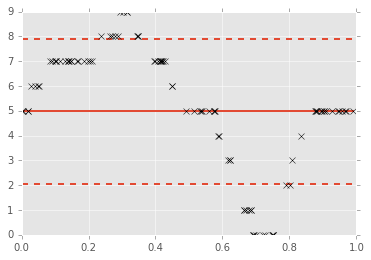

In [10]:
def plot(m):
    plt.figure()
    Xtest = np.linspace(m.X.value.min(), m.X.value.max(), 100).reshape(-1, 1)
    mu, var = m.predict_y(Xtest)
    line, = plt.plot(Xtest, mu, lw=2)
    col=line.get_color()
    plt.plot(Xtest, mu+2*np.sqrt(var), '--', lw=2, color=col)
    plt.plot(Xtest, mu-2*np.sqrt(var), '--', lw=2, color=col)
    plt.plot(m.X.value, m.Y.value, 'kx')
plot(m)

In [5]:
print m


model.Z transform:(none) prior:None [FIXED]
[[ 0.417022  ]
 [ 0.09233859]
 [ 0.41919451]
 [ 0.67046751]
 [ 0.80074457]
 [ 0.89460666]
 [ 0.09834683]
 [ 0.31551563]
 [ 0.98886109]
 [ 0.44789353]
 [ 0.01936696]
 [ 0.05336255]
 [ 0.10233443]
 [ 0.53589641]
 [ 0.90340192]
 [ 0.1653542 ]
 [ 0.88330609]
 [ 0.89588622]
 [ 0.11474597]
 [ 0.23702698]]
model.q_mu transform:(none) prior:None
[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
model.q_sqrt transform:+ve prior:None
[[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]]
model.likelihood.sigma transform:+ve prior:None
[ 1.]
model.kern.matern32.lengthscales transform:+ve prior:None
[ 1.]
model.kern.matern32.variance transform:+ve prior:None
[ 1.]
model.kern.white.variance transform:+ve prior:None [FIXED]
[ 0.01]


In [6]:
m._objective(m.get_free_state())

[438.67545214159537,
 array([ -1.32488841e+01,  -3.77730508e+01,   4.53208994e+00,
          3.12461479e+01,   8.06614283e+00,   1.07541975e+00,
         -3.43913506e+00,  -4.44465856e+00,  -6.24660601e-01,
         -9.95076898e-02,  -3.83998792e-01,  -7.49585489e-01,
         -1.54069499e+00,   1.74512262e+00,   6.76442017e-01,
         -2.17600231e+00,   8.04233443e-01,   4.38930711e-01,
         -9.54754990e-01,  -2.01069213e+00,   4.90008428e+01,
          4.19044314e+00,   2.97204759e-01,   3.97188612e+00,
          8.53607085e-01,   2.65640445e-01,   6.80027756e-02,
          5.41297848e-02,   7.01871995e-02,   1.81233374e-02,
          4.48287647e-02,   9.38331450e-03,   1.01308021e-02,
          2.62350128e-02,   1.21094493e-02,   1.70213502e-02,
          6.74895549e-03,   4.16268309e-03,   4.17995070e-03,
          1.23689197e-02,  -3.49280484e+02,   1.44766530e-16,
          2.95689730e+01])]

In [7]:
m.optimize()

InvalidArgumentError: Input matrix is not invertible.
	 [[Node: MatrixTriangularSolve = MatrixTriangularSolve[T=DT_DOUBLE, adjoint=false, lower=true, _device="/job:localhost/replica:0/task:0/cpu:0"](Cholesky, Add)]]
Caused by op u'MatrixTriangularSolve', defined at:
  File "/Users/james/anaconda/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/james/anaconda/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/james/anaconda/lib/python2.7/site-packages/traitlets/config/application.py", line 592, in launch_instance
    app.start()
  File "/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 403, in start
    ioloop.IOLoop.instance().start()
  File "/Users/james/anaconda/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Users/james/anaconda/lib/python2.7/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/Users/james/anaconda/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/james/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/james/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/james/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/james/anaconda/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 260, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 212, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 370, in execute_request
    user_expressions, allow_stdin)
  File "/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/james/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/james/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/james/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-194412de06a7>", line 4, in <module>
    _ = m.optimize()
  File "/Users/james/work/GPflow/GPflow/model.py", line 193, in optimize
    return self._optimize_np(method, tol, callback, max_iters, **kw)
  File "/Users/james/work/GPflow/GPflow/model.py", line 251, in _optimize_np
    self._compile()
  File "/Users/james/work/GPflow/GPflow/model.py", line 113, in _compile
    f = self.build_likelihood() + self.build_prior()
  File "/Users/james/work/GPflow/GPflow/svgp.py", line 130, in build_likelihood
    self.q_mu, self.q_sqrt, self.num_latent)
  File "/Users/james/work/GPflow/GPflow/conditionals.py", line 115, in gaussian_gp_predict_whitened
    full_cov=full_cov, q_sqrt=q_sqrt, whiten=True)
  File "/Users/james/work/GPflow/GPflow/conditionals.py", line 54, in conditional
    A = tf.matrix_triangular_solve(Lm, Kmn, lower=True)
  File "/Users/james/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 495, in matrix_triangular_solve
    name=name)
  File "/Users/james/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/op_def_library.py", line 704, in apply_op
    op_def=op_def)
  File "/Users/james/anaconda/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2260, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/james/anaconda/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1230, in __init__
    self._traceback = _extract_stack()


In [8]:
debug

> /Users/james/anaconda/lib/python2.7/site-packages/tensorflow/python/client/session.py(728)_do_call()
    726         except KeyError:
    727           pass
--> 728       raise type(e)(node_def, op, message)
    729 
    730   def _extend_graph(self):

ipdb> u
> /Users/james/anaconda/lib/python2.7/site-packages/tensorflow/python/client/session.py(708)_do_run()
    706     if handle is None:
    707       return self._do_call(_run_fn, self._session, feed_dict, fetch_list,
--> 708                            target_list, options, run_metadata)
    709     else:
    710       return self._do_call(_prun_fn, self._session, handle, feed_dict,

ipdb> 
> /Users/james/anaconda/lib/python2.7/site-packages/tensorflow/python/client/session.py(640)_run()
    638       # The movers are no longer used. Delete them.
    639       for handle in movers:
--> 640         self._register_dead_handle(handle)
    641 
    642     # User may have fetched the same tensor multiple times, but we

ipdb>

In [28]:
m.sigma = 1./30000

In [20]:
x = m.get_free_state()
for i in range(1000):
    nll, g = m._objective(x)
    x -= 0.001 * g
    print -nll
    

-225.559556076
-225.505033689
-225.45052934
-225.396034003
-225.34153894
-225.287035683
-225.232516022
-225.177971988
-225.123395842
-225.068780065
-225.01411734
-224.959400547
-224.904622748
-224.84977718
-224.794857246
-224.739856502
-224.684768655
-224.629587549
-224.57430716
-224.518921592
-224.463425064
-224.407811909
-224.352076564
-224.296213568
-224.240217553
-224.184083242
-224.127805443
-224.071379041
-224.014798999
-223.958060352
-223.9011582
-223.844087709
-223.786844104
-223.729422666
-223.671818732
-223.614027685
-223.55604496
-223.497866034
-223.439486427
-223.380901697
-223.322107443
-223.263099294
-223.203872916
-223.144424003
-223.084748279
-223.024841495
-222.964699427
-222.904317874
-222.843692658
-222.782819622
-222.721694626
-222.660313549
-222.598672288
-222.536766752
-222.474592868
-222.412146574
-222.349423818
-222.286420564
-222.223132783
-222.159556455
-222.095687571
-222.031522127
-221.967056129
-221.902285586
-221.837206516
-221.771814941
-221.706106886
-22

In [21]:
m.set_state(x)

43

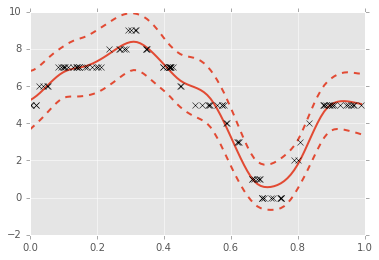

In [22]:
plot(m)

In [23]:
m.optimize()

optimization terminated, setting model state


      fun: 95.658005966316708
 hess_inv: <43x43 LbfgsInvHessProduct with dtype=float64>
      jac: array([  8.03940911e-04,   2.43288833e-03,  -5.83670502e-04,
        -1.76782104e-03,  -3.04780727e-03,  -1.36015148e-04,
         1.04083785e-04,  -3.23365762e-03,  -9.01067700e-04,
        -9.87219730e-04,  -1.91717956e-03,   8.68436900e-04,
        -2.75752776e-04,  -1.23094555e-03,  -3.34668963e-05,
        -1.28322580e-03,  -3.69080130e-04,   1.75715163e-04,
         5.05359016e-06,  -3.31711828e-04,   3.39932295e-04,
         3.11352083e-04,   7.17603954e-05,   2.72307352e-04,
         2.40756075e-04,   1.92453402e-04,   2.14349158e-04,
         2.12097737e-04,   1.84813998e-04,   2.01456933e-04,
         1.27381743e-04,   5.27828252e-04,   6.15098774e-04,
         1.85907400e-04,   3.52442209e-04,   1.95595801e-04,
         3.59050258e-04,   9.39057951e-06,   1.51597492e-04,
         3.51986883e-04,  -1.89511218e-03,   3.33996520e-03,
         1.44284049e-04])
  message: 'CONVERGEN

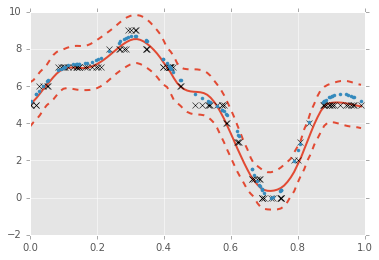

In [29]:
plot(m)
plt.plot(X, f*3 - f.min()*3, '.')

In [30]:
m.likelihood

Name,values,prior,constraint
likelihood.sigma,[ 0.33776359],None,+ve
